In [27]:
import csv
import pandas as pd
import numpy as np
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
import networkx.algorithms.community as nx_comm
from functools import reduce
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import seaborn as sns
from adjustText import adjust_text

In [2]:
file_names = sorted(glob.glob('/Users/davidchen/Documents/GitHub/Topology/amc_topology/Cleaned_Dataset/*.csv', recursive=True))

In [3]:
unique_sites = [x.strip() for x in list(set([x.split("/")[-1].split("-")[0] for x in file_names]))]

In [4]:
folder = '/Users/davidchen/Documents/GitHub/Topology/amc_topology/Cleaned_Dataset'

# Function

In [35]:
def topology(folder, name, node, edge):
    
    #Read Data 

    with open(node, 'r') as nodecsv: # Open the file
        nodereader = csv.reader(nodecsv) # Read the csv
        # Retrieve the data (using Python list comprhension and list slicing to remove the header row, see footnote 3)
        nodes = [n for n in nodereader][1:]

    node_names = [n[1] for n in nodes] # Get a list of only the node names

    with open(edge, 'r') as edgecsv: # Open the file
        edgereader = csv.reader(edgecsv) # Read the csv
        edges = [tuple(e[1:3]) for e in edgereader][1:] # Retrieve the data
        edges = [x for x in edges if x[0] != x[1]] # Remove circular edges; link to itself

    #Build Network

    G = nx.Graph()
    G.add_nodes_from(node_names)
    G.add_edges_from(edges)

    #Remove isolated components

    connected_components_size = [len(x) for x in nx.connected_components(G)]
    if len(connected_components_size) == 1:
        isolated_n = 0
    else:
        isolated_n = max(n for n in connected_components_size if n!=max(connected_components_size))

    G.remove_nodes_from(list(nx.isolates(G)))

    for component in list(nx.connected_components(G)):
        if len(component)<=isolated_n:
            for node in component:
                G.remove_node(node)

    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')

    #Network-wide metrics
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    n_components = nx.number_connected_components(G)
    avg_path_length = nx.average_shortest_path_length(G)
    density = nx.density(G)
    diameter = nx.diameter(G)
    transitivity = nx.transitivity(G)
    avg_clustering = nx.average_clustering(G)
    avg_degree = np.mean(list(dict(G.degree()).values()))
    assortativity = nx.degree_pearson_correlation_coefficient(G)
    modularity = nx_comm.modularity(G, nx_comm.label_propagation_communities(G))
    n_communities = len(nx_comm.label_propagation_communities(G))

    network_df = pd.DataFrame(columns = ['Name', 'Nodes', 'Edges', 'Average Degree', 'Number of Connected Components', 'Average Shortest Path Length', 'Density', 'Diameter', 'Transitivity', 'Average Clustering', 'Assortativity', 'Modularity', 'Number of Communities'])       
    network_df.loc[len(network_df), :] = [name, n_nodes, n_edges, avg_degree, n_components, avg_path_length, density, diameter, transitivity, avg_clustering, assortativity, modularity, n_communities]

    if os.path.isfile(folder + "/" + "summary_network_metrics.tsv") is True:
        network_df.to_csv(folder + "/" + "summary_network_metrics.tsv", sep="\t", header=False, index=False, mode="a")
    else:
        network_df.to_csv(folder + "/" + "summary_network_metrics.tsv", sep="\t", index=False, mode="w")

    #Node-specific metrics
    betweenness = nx.betweenness_centrality(G, normalized=False)
    eigenvector = nx.eigenvector_centrality_numpy(G)
    closeness = nx.closeness_centrality(G)
    eccentricity = nx.eccentricity(G)
    pr = nx.pagerank(G, alpha=0.85)
    clustering = nx.clustering(G)

    nx.set_node_attributes(G, G.degree(), 'degree')
    nx.set_node_attributes(G, betweenness, 'betweenness')
    nx.set_node_attributes(G, eigenvector, 'eigenvector')
    nx.set_node_attributes(G, closeness, 'closeness')
    nx.set_node_attributes(G, eccentricity, 'eccentricity')
    nx.set_node_attributes(G, pr, 'pagerank')
    nx.set_node_attributes(G, clustering, 'clustering')

    degree_df = pd.DataFrame.from_dict(data = dict(G.degree()).items())
    degree_df.columns = ['Node', 'Degree']

    betweenness_df = pd.DataFrame.from_dict(data = betweenness.items())
    betweenness_df.columns = ['Node', 'Betweenness']

    eigenvector_df = pd.DataFrame.from_dict(data = eigenvector.items())
    eigenvector_df.columns = ['Node', 'Eigenvector']

    closeness_df = pd.DataFrame.from_dict(data = closeness.items())
    closeness_df.columns = ['Node', 'Closeness']

    eccentricity_df = pd.DataFrame.from_dict(data = eccentricity.items())
    eccentricity_df.columns = ['Node', 'Eccentricity']

    pr_df = pd.DataFrame.from_dict(data = pr.items())
    pr_df.columns = ['Node', 'PageRank']

    clustering_df = pd.DataFrame.from_dict(data = clustering.items())
    clustering_df.columns = ['Node', 'Clustering']

    node_metrics_df = reduce(lambda left,right: pd.merge(left,right,on='Node'), [degree_df, betweenness_df,  eigenvector_df, closeness_df, eccentricity_df, pr_df, clustering_df])

    node_metrics_df.to_csv(folder + "/" + name + "_node_metrics.tsv", sep="\t", index=False)
    #Network Visualization

    plt.figure(1, figsize=(20,20)) 
    nx.draw(G, 
            pos = nx.spring_layout(G,scale=5, iterations=100),
            node_size = [x*10 for x in list(dict(G.degree).values())],
            edgecolors = "black")
    plt.savefig(folder + "/" + name + '_network.png', dpi=300)
    plt.close()


In [37]:
for site in tqdm(unique_sites):
    name = site
    files_matching_name = [s for s in file_names if site in s]

    node = [s for s in files_matching_name if "Node" in s][0]
    edge = [s for s in files_matching_name if "Internal" in s][0]

    if os.path.isfile(folder + "/" + name + "_node_metrics.tsv"):
        print("Topology Analysis already complete: " + str(name))
    else:
        if (len(node) > 0) & (len(edge) > 0):
            try:
                topology(folder = folder,
                    name = name, 
                     node = node, 
                     edge = edge)
            except:
                print("Failed Topology Analysis: " + str(name))
        else:
            print("No Nodes or Edges Detected: " + str(name))
            
            

100%|████████████████████████████████████████| 40/40 [1:36:59<00:00, 145.48s/it]


# Metrics Visualization

In [7]:
summary_metrics = pd.read_csv(folder + "/" + "summary_network_metrics.tsv", sep="\t")

/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_2379/1796272255.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")
/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_2379/1796272255.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")
/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_2379/1796272255.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")
/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_2379/1796272255.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[3].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")
/var/folders/pf/xlkzjprs0y9dl__s0925l7tc0000gn/T/ipykernel_2379/1796272255.py

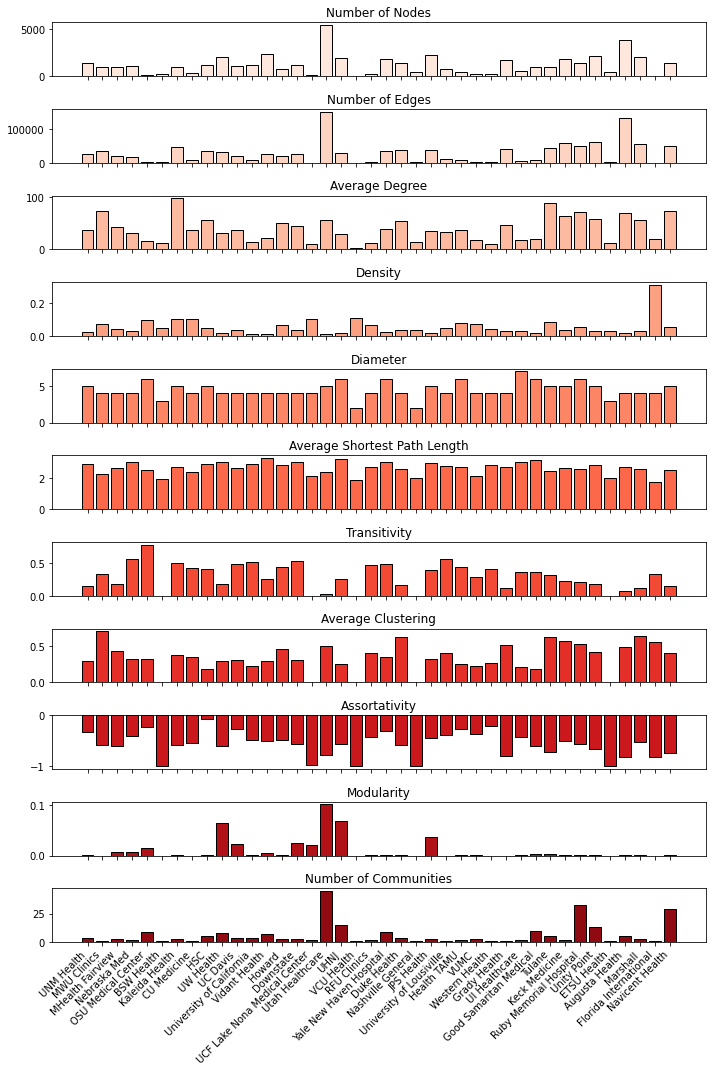

In [23]:
palette = sns.color_palette("Reds", 11)

fig, ax = plt.subplots(11, 1, figsize=(10,15), sharex=True)
ax[0].bar(summary_metrics['Name'], summary_metrics['Nodes'], edgecolor="black", color=palette[0])
ax[0].set_title("Number of Nodes")
ax[0].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[1].bar(summary_metrics['Name'], summary_metrics['Edges'], edgecolor="black", color=palette[1])
ax[1].set_title("Number of Edges")
ax[1].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[2].bar(summary_metrics['Name'], summary_metrics['Average Degree'], edgecolor="black", color=palette[2])
ax[2].set_title("Average Degree")
ax[2].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[3].bar(summary_metrics['Name'], summary_metrics['Density'], edgecolor="black", color=palette[3])
ax[3].set_title("Density")
ax[3].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[4].bar(summary_metrics['Name'], summary_metrics['Diameter'], edgecolor="black", color=palette[4])
ax[4].set_title("Diameter")
ax[4].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[5].bar(summary_metrics['Name'], summary_metrics['Average Shortest Path Length'], edgecolor="black", color=palette[5])
ax[5].set_title("Average Shortest Path Length")
ax[5].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[6].bar(summary_metrics['Name'], summary_metrics['Transitivity'], edgecolor="black", color=palette[6])
ax[6].set_title("Transitivity")
ax[6].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[7].bar(summary_metrics['Name'], summary_metrics['Average Clustering'], edgecolor="black", color=palette[7])
ax[7].set_title("Average Clustering")
ax[7].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[8].bar(summary_metrics['Name'], summary_metrics['Assortativity'], edgecolor="black", color=palette[8])
ax[8].set_title('Assortativity')
ax[8].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[9].bar(summary_metrics['Name'], summary_metrics['Modularity'], edgecolor="black", color=palette[9])
ax[9].set_title('Modularity')
ax[9].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

ax[10].bar(summary_metrics['Name'], summary_metrics['Number of Communities'], edgecolor="black", color=palette[10])
ax[10].set_title('Number of Communities')
ax[10].set_xticklabels(summary_metrics['Name'], rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [25]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(summary_metrics.iloc[:,1:].values)

pca = PCA(n_components=2)
sample_pca = pca.fit_transform(scaled_data)

In [33]:
sample_pca_df = pd.DataFrame(sample_pca)
sample_pca_df['Network'] = summary_metrics['Name']

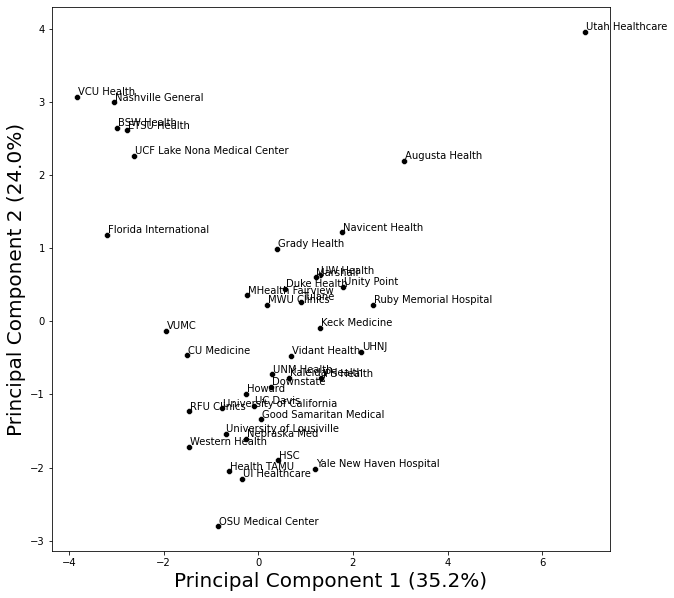

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x=sample_pca[:,0], y=sample_pca[:,1], ax=ax, color="black")

for x in range(40):
    ax.text(sample_pca[x,0]+0.02, sample_pca[x,1]+0.02, summary_metrics['Name'][x])

#texts = []
#for x in range(len(sample_pca_df)):
#    texts.append(plt.text(sample_pca_df.loc[x, 0], sample_pca_df.loc[x, 1], sample_pca_df.loc[x, "Network"], bbox=dict(facecolor='none', edgecolor='black', boxstyle='round')))#

#adjust_text(texts,  only_move = {'points':'xy', 'text':'xy', 'objects':'xy'},
#            arrowprops=dict(arrowstyle="-", color='grey', lw=1),
#           force_points=0,
#           force_text=50,
#           force_objects=50,
#           va="center",
#           precision=5000,
#           expand_text=(1.2, 1.5))

ax.set_xlabel("Principal Component 1 (" + str(round(pca.explained_variance_ratio_[0] * 100, 1)) + "%)", size=20)
ax.set_ylabel("Principal Component 2 (" + str(round(pca.explained_variance_ratio_[1] * 100, 1)) + "%)", size=20)
plt.show()


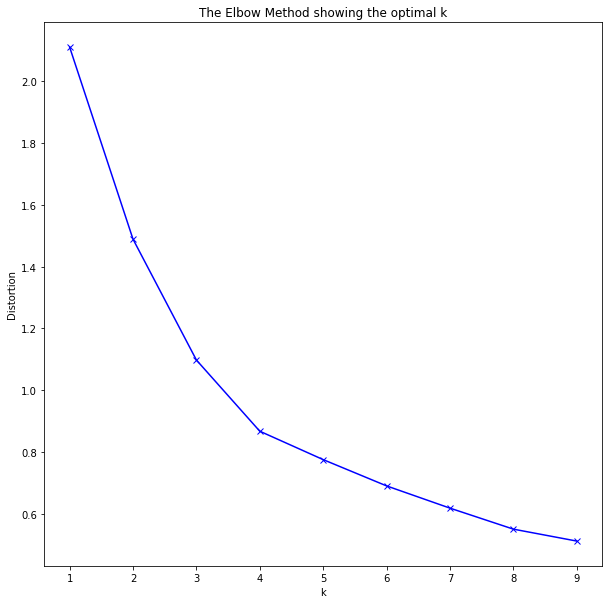

In [47]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

x1 = sample_pca[:,0]
x2 = sample_pca[:,1]

# create new plot and data
fig, ax = plt.subplots(1, 1, figsize=(10,10))
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
ax.plot(K, distortions, 'bx-')
ax.set_xlabel('k')
ax.set_ylabel('Distortion')
ax.set_title('The Elbow Method showing the optimal k')
plt.show()

In [29]:
import plotly.express as px

In [30]:
pca_df = pd.DataFrame(sample_pca)
pca_df['Name'] = summary_metrics['Name']
pca_df.columns = ['Principal Component 1', 'Principal Component 2', 'Name']

fig = px.scatter(pca_df, x='Principal Component 1', y='Principal Component 2', 
                 hover_name="Name", hover_data=["Name"])

fig.show()

# Interactive Network Graph

In [4]:
import plotly.graph_objects as go
import networkx as nx

In [5]:
def build_network(name, node, edge, isolated_n=1):

    #Read Data 
    with open(node, 'r') as nodecsv: # Open the file
        nodereader = csv.reader(nodecsv) # Read the csv
        # Retrieve the data (using Python list comprhension and list slicing to remove the header row, see footnote 3)
        nodes = [n for n in nodereader][1:]

    node_names = [n[1] for n in nodes] # Get a list of only the node names
    
    with open(edge, 'r') as edgecsv: # Open the file
        edgereader = csv.reader(edgecsv) # Read the csv
        edges = [tuple(e[1:3]) for e in edgereader][1:] # Retrieve the data
        edges = [x for x in edges if x[0] != x[1]] # Remove circular edges; link to itself
        
    #Build Network
    
    G = nx.Graph()
    G.add_nodes_from(node_names)
    G.add_edges_from(edges)

    #Remove isolated components
    
    G.remove_nodes_from(list(nx.isolates(G)))

    for component in list(nx.connected_components(G)):
        if len(component)<isolated_n:
            for node in component:
                G.remove_node(node)
                
    degree_dict = dict(G.degree(G.nodes()))
    betweenness = nx.betweenness_centrality(G, normalized=False)
    eigenvector = nx.eigenvector_centrality(G)
    closeness = nx.closeness_centrality(G)
    eccentricity = nx.eccentricity(G)
    pr = nx.pagerank(G, alpha=0.85)
    
    nx.set_node_attributes(G, degree_dict, 'degree')
    nx.set_node_attributes(G, betweenness, 'betweenness')
    nx.set_node_attributes(G, eigenvector, 'eigenvector')
    nx.set_node_attributes(G, closeness, 'closeness')
    nx.set_node_attributes(G, eccentricity, 'eccentricity')
    nx.set_node_attributes(G, pr, 'pagerank')
    
    degree_df = pd.DataFrame.from_dict(data = degree_dict.items())
    degree_df.columns = ['Node', 'Degree']
    
    betweenness_df = pd.DataFrame.from_dict(data = betweenness.items())
    betweenness_df.columns = ['Node', 'Betweenness']

    eigenvector_df = pd.DataFrame.from_dict(data = eigenvector.items())
    eigenvector_df.columns = ['Node', 'Eigenvector']

    closeness_df = pd.DataFrame.from_dict(data = closeness.items())
    closeness_df.columns = ['Node', 'Closeness']

    eccentricity_df = pd.DataFrame.from_dict(data = eccentricity.items())
    eccentricity_df.columns = ['Node', 'Eccentricity']

    pr_df = pd.DataFrame.from_dict(data = pr.items())
    pr_df.columns = ['Node', 'PageRank']
    
    node_metrics_df = reduce(lambda left,right: pd.merge(left,right,on='Node'), [degree_df, betweenness_df, eigenvector_df, closeness_df, eccentricity_df, pr_df])
    
    
    pos = nx.spring_layout(G,scale=5, iterations=100),
    
    return G, pos[0], node_metrics_df

In [8]:
for site in tqdm(unique_sites):
    name = site
    files_matching_name = [s for s in file_names if site in s]

    node = [s for s in files_matching_name if "Node" in s][0]
    edge = [s for s in files_matching_name if "Internal" in s][0]

    if os.path.isfile(folder + "/" + name + ".html"):
        print("Interactive Topology Map already generated: " + str(name))
    else:
        if (len(node) > 0) & (len(edge) > 0):
            try:
                G, pos, metrics_df = build_network(name=name, node=node, edge=edge)

                # edges trace
                edge_x = []
                edge_y = []
                for edge in G.edges():
                    x0, y0 = pos[edge[0]]
                    x1, y1 = pos[edge[1]]
                    edge_x.append(x0)
                    edge_x.append(x1)
                    edge_x.append(None)
                    edge_y.append(y0)
                    edge_y.append(y1)
                    edge_y.append(None)

                edge_trace = go.Scatter(
                    x=edge_x, y=edge_y,
                    line=dict(color='black', width=1),
                    hoverinfo='none',
                    showlegend=False,
                    mode='lines')

                # nodes trace
                node_x = []
                node_y = []
                text = []
                for node in G.nodes():
                    x, y = pos[node]
                    node_x.append(x)
                    node_y.append(y)
                    text.append(node)

                node_trace = go.Scatter(
                    x=node_x, y=node_y,
                    mode='markers',
                    showlegend=False,
                    hoverinfo='text',
                    marker=dict(
                        color='black',
                        size=10,
                        line=dict(color='black', width=1),
                        colorscale='hot',
                    colorbar=dict(
                            thickness=15,
                            title='Node Connections',
                            xanchor='left',
                            titleside='right')),
                    hovertemplate = "<br>Node: %{customdata[0]}<extra></extra>"+\
                                    "<br>Degree: %{customdata[1]: .3f}"+\
                                    "<br>Betweenness: %{customdata[2]: .3f}"+\
                                    "<br>Eigenvector: %{customdata[3]: .3f}"+\
                                    "<br>Closeness: %{customdata[4]: .3f}"+\
                                    "<br>Eccentricity: %{customdata[5]: .3f}"+\
                                    "<br>PageRank: %{customdata[6]: .3f}",
                    customdata = np.stack((metrics_df['Node'],
                         metrics_df['Degree'],
                         metrics_df['Betweenness'],
                         metrics_df['Eigenvector'],
                         metrics_df['Closeness'],
                         metrics_df['Eccentricity'],
                         metrics_df['PageRank']), axis =-1))

                # layout
                layout=go.Layout(plot_bgcolor='white',
                                 paper_bgcolor='white',
                                 hovermode='closest',
                                 showlegend=False,
                                 margin=dict(t=10, b=10, l=10, r=10, pad=0),
                                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                )

                node_adjacencies = []
                for node, adjacencies in enumerate(G.adjacency()):
                    node_adjacencies.append(len(adjacencies[1]))
                node_trace.marker.color = node_adjacencies

                # figure
                fig = go.Figure(data=[edge_trace, node_trace], 
                                layout=layout)

                fig.update_layout(title_text=name)

                fig.write_html(folder + "/" + name + ".html")


            except:
                print("Failed to generate Interactive Topology Map: " + str(name))
        else:
            print("No Nodes or Edges Detected: " + str(name))
            
            
            
            
            



 20%|████████▏                                | 8/40 [14:11<1:55:28, 216.52s/it]

Failed to generate Interactive Topology Map: Utah Healthcare


 57%|████████████████████████▋                  | 23/40 [26:04<08:30, 30.01s/it]

Failed to generate Interactive Topology Map: UCF Lake Nona Medical Center


 60%|█████████████████████████▊                 | 24/40 [26:05<05:47, 21.71s/it]

Failed to generate Interactive Topology Map: ETSU Health


 62%|██████████████████████████▉                | 25/40 [26:06<03:53, 15.55s/it]

Failed to generate Interactive Topology Map: BSW Health


 98%|█████████████████████████████████████████▉ | 39/40 [44:29<01:13, 73.34s/it]

Failed to generate Interactive Topology Map: Nashville General


100%|███████████████████████████████████████████| 40/40 [45:46<00:00, 68.66s/it]


In [13]:
name = "Nashville General"
files_matching_name = [s for s in file_names if site in s]

node = [s for s in files_matching_name if "Node" in s][0]
edge = [s for s in files_matching_name if "Internal" in s][0]

G, pos, metrics_df = build_network(name=name, node=node, edge=edge)

# edges trace
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(color='black', width=1),
    hoverinfo='none',
    showlegend=False,
    mode='lines')

# nodes trace
node_x = []
node_y = []
text = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    showlegend=False,
    hoverinfo='text',
    marker=dict(
        color='black',
        size=10,
        line=dict(color='black', width=1),
        colorscale='hot',
    colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right')),
    hovertemplate = "<br>Node: %{customdata[0]}<extra></extra>"+\
                    "<br>Degree: %{customdata[1]: .3f}"+\
                    "<br>Betweenness: %{customdata[2]: .3f}"+\
                    "<br>Eigenvector: %{customdata[3]: .3f}"+\
                    "<br>Closeness: %{customdata[4]: .3f}"+\
                    "<br>Eccentricity: %{customdata[5]: .3f}"+\
                    "<br>PageRank: %{customdata[6]: .3f}",
    customdata = np.stack((metrics_df['Node'],
         metrics_df['Degree'],
         metrics_df['Betweenness'],
         metrics_df['Eigenvector'],
         metrics_df['Closeness'],
         metrics_df['Eccentricity'],
         metrics_df['PageRank']), axis =-1))

# layout
layout=go.Layout(plot_bgcolor='white',
                 paper_bgcolor='white',
                 hovermode='closest',
                 showlegend=False,
                 margin=dict(t=10, b=10, l=10, r=10, pad=0),
                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                )

node_adjacencies = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
node_trace.marker.color = node_adjacencies

# figure
fig = go.Figure(data=[edge_trace, node_trace], 
                layout=layout)

fig.update_layout(title_text=name)

fig.write_html(folder + "/" + name + ".html")